# Geometrical Optics - Tracing Rays and Calculating Amplitude

In [1]:
import finite_diff as fd
import torch
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
import matplotlib as mpl
from scipy.integrate import solve_ivp, cumulative_trapezoid
from scipy.special import airy
from scipy.interpolate import LinearNDInterpolator
import util as ut
import mgo
from trace_ray import trace_ray, get_t
from torch_helper import to_torch, to_torch_3D, torch_func, inner_product, angle

In [2]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

#### Find first peak

### GO Solution

In [3]:
x0  = -20
phi0 = 1

In [5]:
n0 = 1
R_ne = 5

@torch_func
def n_e(r: ('vector')):
    x, y, z = r
    return torch.exp(- (x**2 + y**2 - R_ne**2)/20)*n0

@torch_func
def D(r: ('vector'), k: ('vector'), omega: ('scalar')):
    x, y, z = r
    return 1 - n_e(r) - inner_product(k, k)

def get_k0(r0):
    return torch.tensor([np.sqrt(1 - n_e(r0)), 0, 0])

In 3D we launch a family of rays satisfying some 2D boundary conditions.

In [8]:
ND = 3
nt, n2, n3 = 100, 100, 3

y0s = np.linspace(-np.abs(x0), np.abs(x0), n2)
z0s = np.linspace(-np.abs(x0), np.abs(x0), n3)

rs = np.zeros((nt, n2, n3, 3))
ks = np.zeros((nt, n2, n3, 3))
omega0 = 1.0

# ray tracing stops when it hits boundary, so we don't know
# exact number of timesteps before ray tracing has completed.
min_nt = nt

for i, y0 in enumerate(y0s):
    for j, z0 in enumerate(z0s):
        tau_ind = (i, j)
        r0 = np.array([x0, y0, z0])
        k0 = get_k0(r0)
        sol = trace_ray(r0 = r0, k0=get_k0(r0), omega0=omega0, tmin=0, tmax=30, D=D, r_max=np.array([-2*x0, 2.5*np.max(y0s), 2.5*np.max(z0s)]), tsteps=nt, rtol=1e-4)
        sol_nt = len(sol.t)
        rs[:sol_nt, i, j, :] = sol.y[:3].T
        ks[:sol_nt, i, j, :] = sol.y[3:].T
        min_nt = np.min((sol_nt, min_nt))

# Clip all rays to the same number of time steps
nt = min_nt
t = sol.t[:min_nt]
rs = rs[:min_nt, :, :, :]
ks = ks[:min_nt, :, :, :]
zs = np.concatenate([rs, ks], axis=-1)

In [10]:
# Calculate GO Field
branch_masks, ray_field = mgo.get_go_field_3D(t, y0s, z0s, zs, phi0)
in_region = mgo.get_covered_region(rs)

The step below takes some time to run (1 minute for `nt, n2 = 100, 100`), and it scales badly with the number of time points and launched rays.

In [11]:
# Get interpolation by superposing ray field from incomming and outgoing branches
interp_field_r, interp_field, branch_interpolations, in_region = mgo.superpose_ray_fields_3D(rs, branch_masks, ray_field, in_region)
interp_field_in_r, interp_field_in, interp_field_out_r, interp_field_out = mgo.get_in_out_interpolations(in_region, branch_interpolations)

### Plots

In [ ]:
xi = np.linspace(-np.abs(x0), np.abs(x0), 1000)
yi = np.linspace(-np.abs(x0), np.abs(x0), 1000)
X, Y = np.meshgrid(xi, yi)

def n_e_xy(x, y):
    r = np.stack([x, y, np.zeros_like(x)])
    return n_e(r)

def n_e_xy_vec(X, Y):
    return n_e_xy(X.reshape(-1), Y.reshape(-1)).reshape(X.shape)

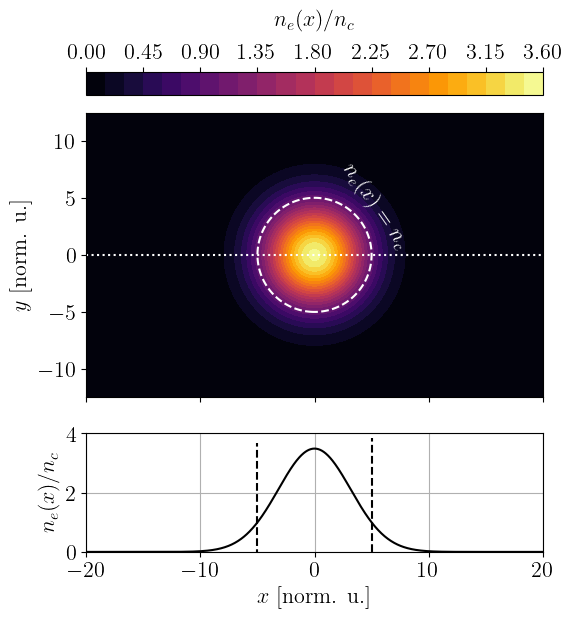

In [13]:
fig, ax = plt.subplots(2, 1, height_ratios=[15, 5], figsize=(6, 6.5))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.sharex(ax2)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1.axis('equal')
cont = ax1.contourf(X, Y, n_e_xy_vec(X, Y), levels=30, cmap='inferno')
cbar = plt.colorbar(cont, orientation='horizontal', location='top')
cbar.set_label('$n_e(x)/n_c$', labelpad=12)
ax1.plot(ax1.get_xlim(), [0, 0], 'w:')
ax1.contour(X, Y, n_e_xy_vec(X, Y), levels=[1], colors=['w'], linestyles=['--'])
ax1.text(5.3, 4.3, r'$n_e(x) = n_c$', rotation=-55, horizontalalignment='center', verticalalignment='center', color='w')
ax1.set_ylabel(r'$y$ [norm. u.]')

ax2.plot(xi, n_e(np.array([xi, np.zeros_like(xi), np.zeros_like(xi)])), 'k')
ax2.grid()
xc = np.sqrt(np.log(n0)+R_ne**2)
ax2.plot([-xc, -xc], ax2.get_ylim(), 'k--')
ax2.plot([xc, xc], ax2.get_ylim(), 'k--')
ax2.set_xlim(-np.abs(x0), np.abs(x0))
ax2.set_ylim(0, 4)
ax2.set_xlabel(r'$x$ [norm. u.]')
ax2.set_ylabel(r'$n_e(x)/n_c$')

plt.tight_layout()

fig.savefig('./plots/circle_ne.pdf')
fig.savefig('./plots/circle_ne.png', dpi=600)
plt.show()

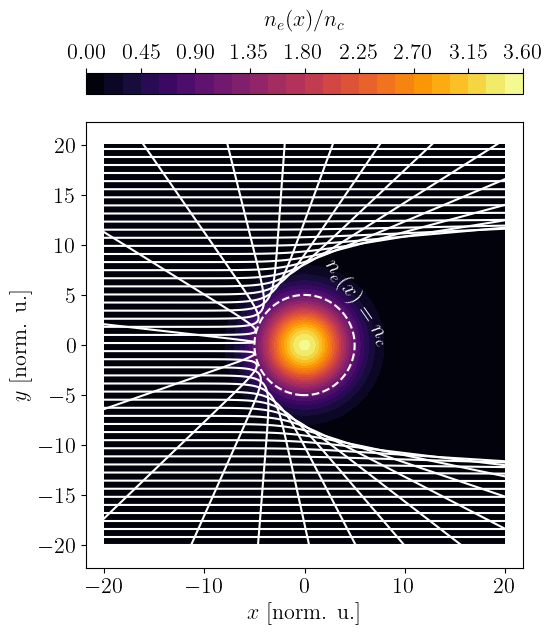

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5.8, 6.7))
ax1 = plt.subplot(111)
ax1.axis('equal')
cont = ax1.contourf(X, Y, n_e_xy_vec(X, Y), levels=30, cmap='inferno')
cbar = plt.colorbar(cont, orientation='horizontal', location='top')
cbar.set_label('$n_e(x)/n_c$', labelpad=12)
ax1.contour(X, Y, n_e_xy_vec(X, Y), levels=[1], colors=['w'], linestyles=['--'])
ax1.plot(rs[:, 0::2, 0, 0], rs[:, 0::2, 0, 1], '-w')
ax1.text(5.3, 4.3, r'$n_e(x) = n_c$', rotation=-55, horizontalalignment='center', verticalalignment='center', color='w')
ax1.set_xlabel(r'$x$ [norm. u.]')
ax1.set_ylabel(r'$y$ [norm. u.]')
ax1.set_xlim(np.min(xi), np.max(xi))
ax1.set_ylim(np.min(yi), np.max(yi))

plt.tight_layout()
fig.savefig('./plots/circle_rays_on_ne.pdf')
fig.savefig('./plots/circle_rays_on_ne.png', dpi=600)
plt.show()

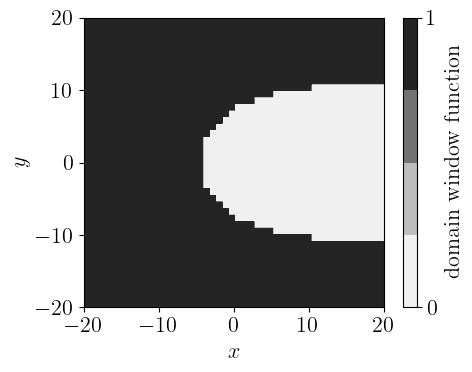

In [19]:
plt.figure(figsize=(5,4))
in_region = mgo.get_covered_region(rs)
plt.contourf(X, Y, in_region((X, Y, np.zeros_like(X))), levels=3, cmap='Greys')
plt.colorbar(label='domain window function', ticks=[0, 1])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.tight_layout()
plt.show()

In [20]:
xi = np.linspace(-np.abs(x0), np.abs(x0), 5*nt)
yi = np.linspace(-np.abs(x0), np.abs(x0), 5*n2)
X, Y = np.meshgrid(xi, yi)
E_mgo = interp_field(X, Y, np.zeros_like(X))
E_in = interp_field_in(X, Y, np.zeros_like(X))
E_out = interp_field_out(X, Y, np.zeros_like(X))

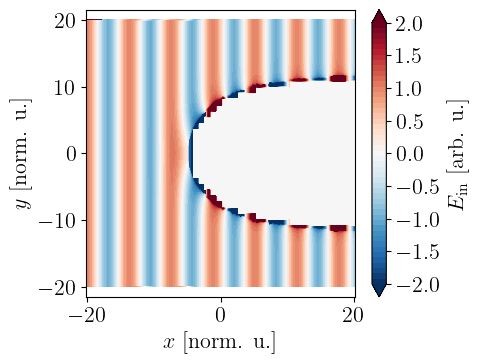

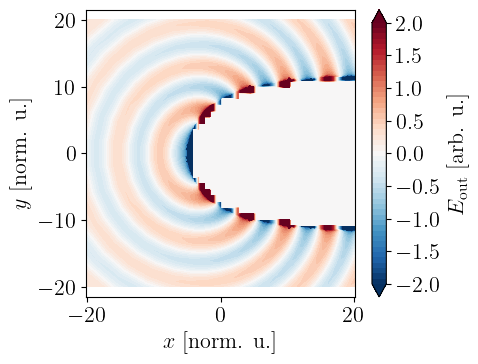

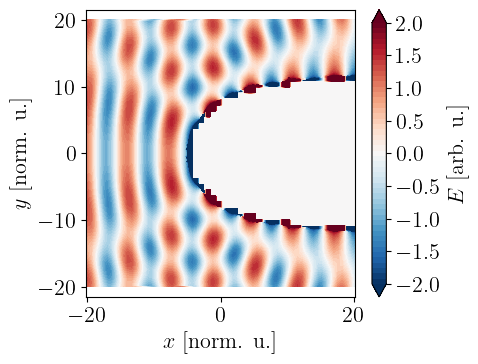

In [69]:
vmin, vmax = -2, 2

plt.figure(figsize=(5, 4))
plt.axis('equal')
plt.contourf(X, Y, np.real(E_in), vmin=vmin, vmax=vmax, cmap='RdBu_r', extend='both')
cont = plt.contourf(X, Y, np.real(E_in), levels=np.linspace(vmin, vmax, 50), cmap='RdBu_r', extend='both')
plt.colorbar(cont, ticks=np.linspace(-2, 2, 9), label=r'$E_\mathrm{in}$ [arb. u.]')
plt.xlabel(r'$x$ [norm. u.]')
plt.ylabel(r'$y$ [norm. u.]')
plt.tight_layout()
plt.savefig('./plots/circle_E_in_go.png', dpi=600)

plt.figure(figsize=(5, 4))
plt.axis('equal')
plt.contourf(X, Y, np.real(E_out), vmin=vmin, vmax=vmax, cmap='RdBu_r', extend='both')
cont = plt.contourf(X, Y, np.real(E_out), levels=np.linspace(vmin, vmax, 50), cmap='RdBu_r', extend='both')
plt.colorbar(cont, ticks=np.linspace(-2, 2, 9), label=r'$E_\mathrm{out}$ [arb. u.]')
plt.xlabel(r'$x$ [norm. u.]')
plt.ylabel(r'$y$ [norm. u.]')
plt.tight_layout()
plt.savefig('./plots/circle_E_out_go.png', dpi=600)

plt.figure(figsize=(5, 4))
plt.axis('equal')
plt.contourf(X, Y, np.real(E_mgo), vmin=vmin, vmax=vmax, cmap='RdBu_r', extend='both')
cont = plt.contourf(X, Y, np.real(E_mgo), levels=np.linspace(vmin, vmax, 50), cmap='RdBu_r', extend='both')
plt.colorbar(cont, ticks=np.linspace(-2, 2, 9), label=r'$E$ [arb. u.]')
plt.xlabel(r'$x$ [norm. u.]')
plt.ylabel(r'$y$ [norm. u.]')
plt.tight_layout()
plt.savefig('./plots/circle_E_go.png', dpi=600)

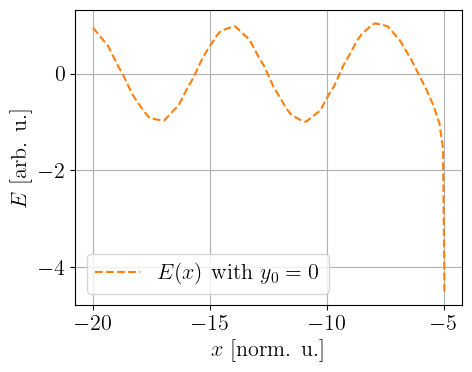

In [88]:
xi = np.linspace(x0, -xc, 1000)
E_1D = interp_field(xi, np.zeros_like(xi), np.zeros_like(xi))
plt.figure(figsize=(5, 4))
plt.plot(xi, np.real(E_1D), '--', color='tab:orange', label=r'$E(x)$ with $y_0=0$')
plt.xlabel(r'$x$ [norm. u.]')
plt.ylabel(r'$E$ [arb. u.]')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('./plots/circle_E_1D.pdf')
plt.savefig('./plots/circle_E_1D.png', dpi=300)

#### Dispersion Manifold Plot

In [176]:
# %matplotlib qt

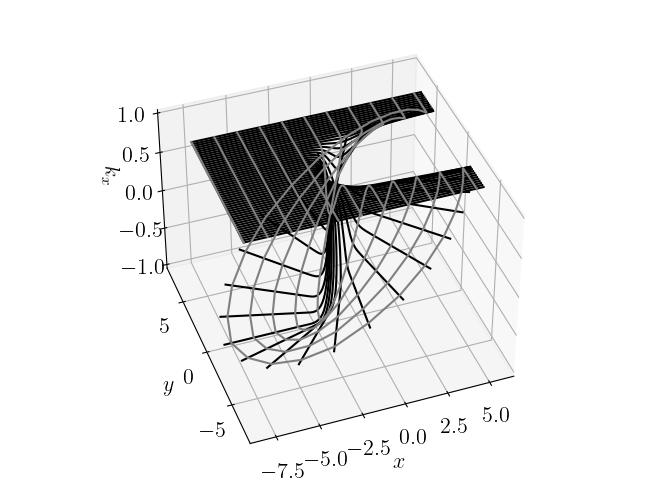

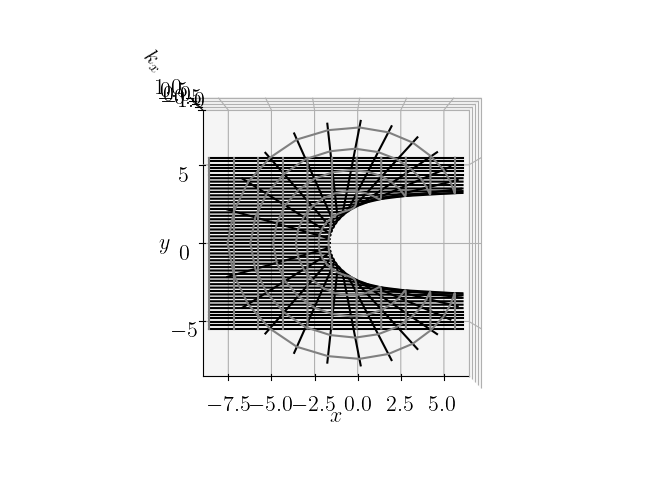

In [179]:
import numpy as np
import matplotlib.pyplot as plt


def plot_disp_manifold(ax, view_init=(40, -110, 0)):
    for i, y0 in enumerate(y0s):
        ax.plot(rs[:, i, 0, 0], rs[:, i, 0, 1], ks[:, i, 0, 0], 'k-')
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$y$')
        ax.set_zlabel(r'$k_x$')
    for i in range(0, len(t), int(len(t)/10)):
        ax.plot(rs[i, :, 0, 0], rs[i, :, 0, 1], ks[i, :, 0, 0], '-', color='grey')
    ax.view_init(*view_init)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plot_disp_manifold(ax)
plt.tight_layout()
fig.add_axes([0,0,1,1]).axis("off")
plt.savefig('./plots/circle_dispersion_manifold_angle_1.png')
plt.savefig('./plots/circle_dispersion_manifold_angle_1.pdf')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plot_disp_manifold(ax, view_init=(90, 0, 90))
plt.tight_layout()
fig.add_axes([0,0,1,1]).axis("off")
plt.savefig('./plots/circle_dispersion_manifold_angle_2.png')
plt.savefig('./plots/circle_dispersion_manifold_angle_2.pdf')

plt.show()


In [178]:
%matplotlib inline

#### Cover Page Plot

In [ ]:
# Cover page Plot
xmax = 20
xi = np.linspace(-xmax, xmax, 1000)
yi = np.linspace(-xmax*14.5/21, xmax*14.5/21, 1000)
X, Y = np.meshgrid(xi, yi, indexing='ij')

cm = 1/2.54 # 1 cm = 1/2.54 inch
fig, ax = plt.subplots(1, 1, figsize=(21*cm, 14.5*cm))
ax1 = plt.subplot(111)
# ax1.axis('equal')
ax1.set_axis_off()
cont = ax1.contourf(X, Y, n_e_xy_vec(X, Y), levels=20, cmap='inferno')
ax1.contour(X, Y, n_e_xy_vec(X, Y), levels=[1], colors=['w'], linestyles=['--'])
ax1.plot(rs[:, 0::2, 0, 0], rs[:, 0::2, 0, 1], '-w')
ax1.set_xlim(-xmax, xmax)
ax1.set_ylim(np.min(yi), np.max(yi))

# plt.tight_layout()
fig.savefig('./plots/cover_page.png', dpi=600, bbox_inches='tight')
plt.show()